# CONFIG

In [1]:
# Need to be the same in strats_notebook.ipynb and clutering_STraTS_encoder.ipynb 
HYPER_PARAM = {'d_var':40, 'd_demo':10, 'N':2, 'he':4, 'dropout':0.2}
DATA_SET = 'bodo' # can be {'bodo', 'physionet'}
MIN_LENGTH_OF_STAY = 4
MAX_LENGTH_OF_STAY = 60
SAMPLES_TO_PREDICT = 1
WARD_TO_USE = 'WardALL'                             # alternatives {'Ward2','Ward3','WardALL','WardNO'}
STATIC_VARIS = ['Gender', 'StaticImputed', 'WardID', 'WardChange']          # alternatives ['Gender', 'StaticImputed', 'WardChange', 'Unconscious', 'WardID'  + in physionet 'weight', 'Age']
DROP_VAIRS = []
USE_DAY_MEAN = ''       # '', '_dayMean'  take mean of values for each day.
IMPUTE_GENDER = '_ImputeGender' # '_ImputeGender'  impute gender with random gender with same rate as data.
REMOVE_MISSING_GENDER = '' # '_noMissGender'  remove patient if gender is missing.


In [2]:
# Unique for this file:
DATA_PATH = './data/'
DATA_NAME = f'triplets_{DATA_SET}_O{MIN_LENGTH_OF_STAY}U{MAX_LENGTH_OF_STAY}_{WARD_TO_USE}{IMPUTE_GENDER}{REMOVE_MISSING_GENDER}{USE_DAY_MEAN}.pkl'
SAVE_WEIGHTS_AS = f'weight_{DATA_SET}_O{MIN_LENGTH_OF_STAY}U{MAX_LENGTH_OF_STAY}_{WARD_TO_USE}_SV{STATIC_VARIS}_pred{SAMPLES_TO_PREDICT}{IMPUTE_GENDER}{REMOVE_MISSING_GENDER}{USE_DAY_MEAN}_d_var{HYPER_PARAM["d_var"]}demo{HYPER_PARAM["d_demo"]}.h5'

# STATIC_VARIS = []

SAVE_WEIGHTS_AS

"weight_bodo_O4U60_WardALL_SV['Gender', 'StaticImputed', 'WardID', 'WardChange']_pred1_ImputeGender_d_var40demo10.h5"

In [3]:
from tensorflow.config.experimental import list_physical_devices
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.models import Model
import pickle
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping
import pandas as pd
# making tf_utils.smart_cond work with latest version of tensorflow 2.xx

from tensorflow.python.framework import smart_cond as smart_module
from tensorflow.python.ops import control_flow_ops, variables
import time


def smart_cond(pred, true_fn=None, false_fn=None, name=None):
  if isinstance(pred, variables.Variable):
    return control_flow_ops.cond(
        pred, true_fn=true_fn, false_fn=false_fn, name=name)
  return smart_module.smart_cond(
      pred, true_fn=true_fn, false_fn=false_fn, name=name)

In [4]:
# check for GPU
print("Num GPUs Available: ", len(list_physical_devices('GPU')))

Num GPUs Available:  1


## Load forecast dataset into matrices.

In [5]:

# Read data.
if DATA_SET=='physionet':
    data, oc, train_ind, valid_ind, test_ind = pickle.load(open(DATA_PATH+'physionet_2012_preprocessed_noNormalization.pkl', 'rb'))

    static_varis = STATIC_VARIS 

    feat_dynamic = [
        'HR',           # [Heart rate (bpm)]
        'NIDiasABP',    # [Non-invasive diastolic arterial blood pressure (mmHg)]
        'NISysABP',     # [Non-invasive systolic arterial blood pressure (mmHg)]
        'PaO2',         # [Partial pressure of arterial O2 (mmHg)]
        'RespRate',     # [Respiration rate (bpm)]
        'SaO2',         # [O2 saturation in hemoglobin (%)]
        'Temp',         # [Temperature (°C)]
        # Features not in Bodo data below.
        # 'Albumin',      # (g/dL)
        # 'ALP',          # [Alkaline phosphatase (IU/L)]
        # 'ALT',          # [Alanine transaminase (IU/L)]
        # 'AST',          # [Aspartate transaminase (IU/L)]
        # 'Bilirubin',    # (mg/dL)
        # 'BUN',          # [Blood urea nitrogen (mg/dL)]
        # 'Cholesterol',  # (mg/dL)
        # 'Creatinine',   # [Serum creatinine (mg/dL)]
        # 'DiasABP',      # [Invasive diastolic arterial blood pressure (mmHg)]
        # 'FiO2',         # [Fractional inspired O2 (0-1)]
        # 'GCS',          # [Glasgow Coma Score (3-15)]
        # 'Glucose',      # [Serum glucose (mg/dL)]
        # 'HCO3',         # [Serum bicarbonate (mmol/L)]
        # 'HCT',          # [Hematocrit (%)]
        # 'K',            # [Serum potassium (mEq/L)]
        # 'Lactate',      # (mmol/L)
        # 'Mg',           # [Serum magnesium (mmol/L)]
        # 'MAP',          # [Invasive mean arterial blood pressure (mmHg)]
        # 'MechVent',     # [Mechanical ventilation respiration (0:false, or 1:true)]
        # 'Na',           # [Serum sodium (mEq/L)]
        # 'NIMAP',        # [Non-invasive mean arterial blood pressure (mmHg)]
        # 'PaCO2',        # [partial pressure of arterial CO2 (mmHg)]
        # 'pH',           # [Arterial pH (0-14)]
        # 'Platelets',    # (cells/nL)
        # 'SysABP',       # [Invasive systolic arterial blood pressure (mmHg)]
        # 'TropI',        # [Troponin-I (μg/L)]
        # 'TropT',        # [Troponin-T (μg/L)]
        # 'Urine',        # [Urine output (mL)]
        # 'WBC'           # [White blood cell count (cells/nL)]
        ]

    data = data.loc[data.variable.isin(feat_dynamic)]

    

    # max_hour = int(data.hour.max())

    MIN = MIN_LENGTH_OF_STAY
    MAX = MAX_LENGTH_OF_STAY
    if USE_DAY_MEAN == '_dayMean':  # should be 4 samples per day 
        MIN = MIN_LENGTH_OF_STAY // 4 
        MAX = MAX_LENGTH_OF_STAY // 4
    obs_windows = range(MIN-10, MAX, 10)

elif DATA_SET=='bodo':
    datapath = DATA_PATH+DATA_NAME
    data, oc, train_ind, valid_ind, test_ind = pickle.load(open(DATA_PATH+DATA_NAME, 'rb'))

    static_varis = STATIC_VARIS # ['Gender']
    # max_hour = int(data.checkup.max())
    MIN = MIN_LENGTH_OF_STAY
    MAX = MAX_LENGTH_OF_STAY
    if USE_DAY_MEAN == '_dayMean':  # should be 4 samples per day 
        print('USE_DAY_MEAN is on')
        MIN = MIN_LENGTH_OF_STAY // 4 
        MAX = MAX // 4
    obs_windows = range(MIN, MAX,  1)
    

else:
    print('cant find data, specify: DATA_PATH and DATA_NAME')

print('Unsing data from:', datapath)
print('patients in data:', len(data.PatientID.unique()))
data

Unsing data from: ./data/triplets_bodo_O4U60_WardALL_ImputeGender.pkl
patients in data: 17037


,ts_ind,PatientID,checkup,hour,variable,value,mean,std,Timestamp
0,0,191533,0,0.000000,WardID,8,0,1,1.649650e+12
1,0,191533,1,7.373056,WardID,8,0,1,1.649676e+12
2,0,191533,2,15.517500,WardID,8,0,1,1.649705e+12
3,0,191533,3,25.445833,WardID,8,0,1,1.649741e+12
4,0,191533,0,0.000000,Systolic,-0.51572,11.569301,22.433311,1.649650e+12
...,...,...,...,...,...,...,...,...,...
1963771,17036,321815932,2,17.591944,StaticImputed,0,0,1,1.659435e+12
1963772,17036,321815932,3,23.622500,StaticImputed,0,0,1,1.659457e+12
1963773,17036,321815932,4,28.755556,StaticImputed,0,0,1,1.659476e+12
1963774,17036,321815932,5,40.854167,StaticImputed,0,0,1,1.659519e+12


# Preprocess data into forcast chunks

In [6]:
# Remove test patients.
test_sub = oc.loc[oc.ts_ind.isin(test_ind)].ts_ind.unique()
data = data.loc[~data.ts_ind.isin(test_sub)]
oc = oc.loc[~oc.ts_ind.isin(test_sub)]

# Remove unwanted variables.
data = data[~data['variable'].isin(DROP_VAIRS)]

# Fix age.
data.loc[(data.variable=='Age')&(data.value>200), 'value'] = 91.4
# Get static data with mean fill and missingness indicator.
ii = data.variable.isin(static_varis)
static_data = data.loc[ii]
data = data.loc[~ii]
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
static_var_to_ind = inv_list(static_varis)
D = len(static_varis)
N = data.ts_ind.max()+1
demo = np.zeros((N, D))
for row in tqdm(static_data.itertuples()):
    demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value
# Normalize static data.
means = demo.mean(axis=0, keepdims=True)
stds = demo.std(axis=0, keepdims=True)
stds = (stds==0)*1 + (stds!=0)*stds
demo = (demo-means)/stds

# Get variable indices.
varis = sorted(list(set(data.variable)))
V = len(varis)
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data[['ts_ind', 'vind', 'checkup', 'value']].sort_values(by=['ts_ind', 'vind', 'checkup'])
# Find max_len.
# fore_max_len = 880 # original
fore_max_len = MAX_LENGTH_OF_STAY # No need for longer than max amount of datapoints for each patient?
# Get forecast inputs and outputs.
fore_times_ip = []
fore_values_ip = []
fore_varis_ip = []
fore_op = []
fore_inds = []
def f(x):
    mask = [0 for i in range(V)]
    values = [0 for i in range(V)]
    for vv in x:
        v = int(vv[0])-1
        mask[v] = 1
        values[v] = vv[1]
    return values+mask
def pad(x):
    return x+[0]*(fore_max_len-len(x))
for w in tqdm(obs_windows):
    # predicted data: from timestep w and SAMPLES_TO_PREDICT forward.
    pred_data = data.loc[(data.checkup>=w)&(data.checkup<w+SAMPLES_TO_PREDICT)]
    pred_data = pred_data.groupby(['ts_ind', 'vind']).agg({'value':'first'}).reset_index()
    pred_data['vind_value'] = pred_data[['vind', 'value']].values.tolist()
    pred_data = pred_data.groupby('ts_ind').agg({'vind_value':list}).reset_index()
    pred_data['vind_value'] = pred_data['vind_value'].apply(f)   
    
    # observed data: from timestep w and 24h before that.  
    # obs_data = data.loc[(data.hour<w)&(data.hour>=w-24)] # Original STraTS only uses data within a set timeframe,
    obs_data = data.loc[(data.checkup<w)]#&(data.hour>=w-24)] # We are using all previous data since it is so sparce anyway.

    obs_data = obs_data.loc[obs_data.ts_ind.isin(pred_data.ts_ind)]
    obs_data = obs_data.groupby('ts_ind').head(fore_max_len)
    obs_data = obs_data.groupby('ts_ind').agg({'vind':list, 'checkup':list, 'value':list}).reset_index()
    obs_data = obs_data.merge(pred_data, on='ts_ind')
    for col in ['vind', 'checkup', 'value']:
        obs_data[col] = obs_data[col].apply(pad)
    fore_op.append(np.array(list(obs_data.vind_value)))
    fore_inds.append(np.array(list(obs_data.ts_ind)))
    fore_times_ip.append(np.array(list(obs_data.checkup)))
    fore_values_ip.append(np.array(list(obs_data.value)))
    fore_varis_ip.append(np.array(list(obs_data.vind)))

    


del data
fore_times_ip = np.concatenate(fore_times_ip, axis=0)
fore_values_ip = np.concatenate(fore_values_ip, axis=0)
fore_varis_ip = np.concatenate(fore_varis_ip, axis=0)
fore_op = np.concatenate(fore_op, axis=0)
fore_inds = np.concatenate(fore_inds, axis=0)
fore_demo = demo[fore_inds]
# Get train and valid ts_ind for forecast task.
train_sub = oc.loc[oc.ts_ind.isin(train_ind)].ts_ind.unique()
valid_sub = oc.loc[oc.ts_ind.isin(valid_ind)].ts_ind.unique()
rem_sub = oc.loc[~oc.ts_ind.isin(np.concatenate((train_ind, valid_ind)))].ts_ind.unique() 
# rem_sub: remaining sub gets added to training and validation subs. 
bp = int(0.8*len(rem_sub))
train_sub = np.concatenate((train_sub, rem_sub[:bp]))
valid_sub = np.concatenate((valid_sub, rem_sub[bp:]))
train_ind = oc.loc[oc.ts_ind.isin(train_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.
valid_ind = oc.loc[oc.ts_ind.isin(valid_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.
# Generate 3 sets of inputs and outputs.
train_ind = np.argwhere(np.in1d(fore_inds, train_ind)).flatten()
valid_ind = np.argwhere(np.in1d(fore_inds, valid_ind)).flatten()
fore_train_ip = [ip[train_ind] for ip in [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]]
fore_valid_ip = [ip[valid_ind] for ip in [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]]
# del fore_times_ip, fore_values_ip, fore_varis_ip, demo, fore_demo
fore_train_op = fore_op[train_ind]
fore_valid_op = fore_op[valid_ind]
del fore_op



407124it [00:00, 1152752.21it/s]
100%|██████████| 56/56 [00:15<00:00,  3.69it/s]


## Load target dataset into matrices.

In [7]:

# Read data.
if DATA_SET=='physionet':
    data, oc, train_ind, valid_ind, test_ind = pickle.load(open(DATA_PATH+'physionet_2012_preprocessed_noNormalization.pkl', 'rb'))
    data = data.loc[data.variable.isin(feat_dynamic)]




elif DATA_SET=='bodo':
    data, oc, train_ind, valid_ind, test_ind = pickle.load(open(DATA_PATH+DATA_NAME, 'rb'))

else:
    print('cant find data, specify: DATA_PATH and DATA_NAME')

print('Data in use: ', DATA_PATH+DATA_NAME)


# Filter labeled data in first 24h.
data = data.loc[data.ts_ind.isin(np.concatenate((train_ind, valid_ind, test_ind), axis=-1))]
data = data.loc[(data.hour>=0)&(data.hour<=24)]
if 'StaticImputed' not in static_varis:
        try:
            data = data[data['variable'] != 'StaticImputed']
            print('Dropped StaticImputed')
        except:
            print('No StaticImputed in data')
oc = oc.loc[oc.ts_ind.isin(np.concatenate((train_ind, valid_ind, test_ind), axis=-1))]
# Fix age.
data.loc[(data.variable=='Age')&(data.value>200), 'value'] = 91.4
# Get y and N.
y = np.array(oc.sort_values(by='ts_ind')['in_hospital_mortality']).astype('float32')
N = data.ts_ind.max() + 1
# Get static data with mean fill and missingness indicator.
ii = data.variable.isin(static_varis)
static_data = data.loc[ii]
data = data.loc[~ii]
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
static_var_to_ind = inv_list(static_varis)
D = len(static_varis)
demo = np.zeros((N, D))
for row in tqdm(static_data.itertuples()):
    demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value
# Normalize static data.
means = demo.mean(axis=0, keepdims=True)
stds = demo.std(axis=0, keepdims=True)
stds = (stds==0)*1 + (stds!=0)*stds
demo = (demo-means)/stds


if DATA_SET=='physionet':
    # normalize with ideal values, Bodo features
    # opt_val = [['PatientID','WardID','Timestamp', 'Systolic', 'Diastolic', 'O2', 'Pulse', 'Temp', 'Rf', 'Gender', 'onO2',   'Unconscious', 'EwsScore', 'StaticImputed']]
    # opt_val = [     0,          0,          0,          120,        80,      96,    70,     37,     16,     0,        0,             0,       0,              0 ]

    data.loc[data.variable == 'HR', 'value'] -= 70
    data.loc[data.variable == 'RespRate', 'value'] -= 16
    data.loc[data.variable == 'Temp', 'value'] -= 37
    data.loc[data.variable == 'SaO2', 'value'] -= 96
    data.loc[data.variable == 'NIDiasABP', 'value'] -= 80
    data.loc[data.variable == 'NISysABP', 'value'] -= 120

    # Add columns to the data: checkup, number of checkups on the patient at the given row
    patient_ids = data.ts_ind.unique()
    data_grouped = data.groupby('ts_ind')
    def generate_checkups(patient_data):
        reps = patient_data['hour'].value_counts(sort=False)
        checkups = np.repeat(np.arange(len(reps)), reps)
        return pd.DataFrame({'checkup': checkups})

    df_checkup = data_grouped.apply(generate_checkups).reset_index(level=1, drop=True).reset_index()
    data['checkup'] = df_checkup['checkup'].values

    # Add columns to the data: PatientID, same as ts_ind for Physionet
    data['PatientID'] = data['ts_ind']
    data = data[['ts_ind', 'PatientID', 'checkup', 'hour', 'variable', 'value', 'mean', 'std']]

    # Drop patients with less than MIN_LENGTH_OF_STAY different times with datasamples
    droppedID = data[data_grouped['checkup'].transform('max') <= MIN_LENGTH_OF_STAY]['ts_ind'].unique()
    data = data[~data['ts_ind'].isin(droppedID)]
    print(f'Dropped {len(droppedID)} patients with less then MIN_LENGTH_OF_STAY:{MIN_LENGTH_OF_STAY} samples.')


# Trim to max len.
data = data.sample(frac=1)
data = data.groupby('ts_ind').head(880)
# Get N, V, var_to_ind.
N = data.ts_ind.max() + 1
varis = sorted(list(set(data.variable)))
V = len(varis)
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data[['ts_ind', 'vind', 'hour', 'value']].sort_values(by=['ts_ind', 'vind', 'hour'])
# Add obs index.
data = data.sort_values(by=['ts_ind']).reset_index(drop=True)
data = data.reset_index().rename(columns={'index':'obs_ind'})
data = data.merge(data.groupby('ts_ind').agg({'obs_ind':'min'}).reset_index().rename(columns={ \
                                                            'obs_ind':'first_obs_ind'}), on='ts_ind')
data['obs_ind'] = data['obs_ind'] - data['first_obs_ind']
# Find max_len.
max_len = data.obs_ind.max()+1
# print ('max_len', max_len)
# Generate times_ip and values_ip matrices.
times_inp = np.zeros((N, max_len), dtype='float32')
values_inp = np.zeros((N, max_len), dtype='float32')
varis_inp = np.zeros((N, max_len), dtype='int32')
for row in tqdm(data.itertuples()):
    ts_ind = row.ts_ind
    l = row.obs_ind
    times_inp[ts_ind, l] = row.hour
    values_inp[ts_ind, l] = row.value
    varis_inp[ts_ind, l] = row.vind
data.drop(columns=['obs_ind', 'first_obs_ind'], inplace=True)

# Generate 3 sets of inputs and outputs.
train_ip = [ip[train_ind] for ip in [demo, times_inp, values_inp, varis_inp]]
valid_ip = [ip[valid_ind] for ip in [demo, times_inp, values_inp, varis_inp]]
test_ip = [ip[test_ind] for ip in [demo, times_inp, values_inp, varis_inp]]
del times_inp, values_inp, varis_inp
train_op = y[train_ind]
valid_op = y[valid_ind]
test_op = y[test_ind]
del y

# y = np.concatenate((train_op,valid_op,test_op))
# y.sum()/len(y)

Data in use:  ./data/triplets_bodo_O4U60_WardALL_ImputeGender.pkl


164160it [00:00, 1085753.26it/s]
492480it [00:00, 922607.76it/s]


## Define metrics and losses.

In [8]:
def get_res(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    minrp = np.minimum(precision, recall).max()
    roc_auc = roc_auc_score(y_true, y_pred)
    return [roc_auc, pr_auc, minrp]
    
class_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=train_op)
def mortality_loss(y_true, y_pred):
    sample_weights = (1-y_true)*class_weights[0] + y_true*class_weights[1]
    bce = K.binary_crossentropy(y_true, y_pred)
    return K.mean(sample_weights*bce, axis=-1)

def forecast_loss(y_true, y_pred):
    return K.sum(y_true[:,V:]*(y_true[:,:V]-y_pred)**2, axis=-1)

def get_min_loss(weight):
    def min_loss(y_true, y_pred):
        return weight*y_pred
    return min_loss

class CustomCallback(Callback):
    def __init__(self, validation_data, batch_size):
        self.val_x, self.val_y = validation_data
        self.batch_size = batch_size
        super(Callback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.val_x, verbose=0, batch_size=self.batch_size)
        if type(y_pred)==type([]):
            y_pred = y_pred[0]
        precision, recall, thresholds = precision_recall_curve(self.val_y, y_pred)
        pr_auc = auc(recall, precision)
        roc_auc = roc_auc_score(self.val_y, y_pred)
        logs['custom_metric'] = pr_auc + roc_auc
        print ('val_aucs:', pr_auc, roc_auc)

## Define model architecture.

In [9]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, Activation, Dropout, Softmax, Layer, InputSpec, Input, Dense, Lambda, TimeDistributed, Concatenate, Add
from tensorflow.keras import initializers, regularizers, constraints, Model
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow import nn

    
class CVE(Layer):
    def __init__(self, hid_units, output_dim):
        self.hid_units = hid_units
        self.output_dim = output_dim
        super(CVE, self).__init__()
        
    def build(self, input_shape): 
        self.W1 = self.add_weight(name='CVE_W1',
                            shape=(1, self.hid_units),
                            initializer='glorot_uniform',
                            trainable=True)
        self.b1 = self.add_weight(name='CVE_b1',
                            shape=(self.hid_units,),
                            initializer='zeros',
                            trainable=True)
        self.W2 = self.add_weight(name='CVE_W2',
                            shape=(self.hid_units, self.output_dim),
                            initializer='glorot_uniform',
                            trainable=True)
        super(CVE, self).build(input_shape)
        
    def call(self, x):
        x = K.expand_dims(x, axis=-1)
        x = K.dot(K.tanh(K.bias_add(K.dot(x, self.W1), self.b1)), self.W2)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape + (self.output_dim,)
    
    
class Attention(Layer):
    
    def __init__(self, hid_dim):
        self.hid_dim = hid_dim
        super(Attention, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        self.W = self.add_weight(shape=(d, self.hid_dim), name='Att_W',
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.hid_dim,), name='Att_b',
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.hid_dim,1), name='Att_u',
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e30):
        attn_weights = K.dot(K.tanh(K.bias_add(K.dot(x,self.W), self.b)), self.u)
        mask = K.expand_dims(mask, axis=-1)
        attn_weights = mask*attn_weights + (1-mask)*mask_value
        attn_weights = K.softmax(attn_weights, axis=-2)
        return attn_weights
        
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1,)
    
    
class Transformer(Layer):
    
    def __init__(self, N=2, h=8, dk=None, dv=None, dff=None, dropout=0):
        self.N, self.h, self.dk, self.dv, self.dff, self.dropout = N, h, dk, dv, dff, dropout
        self.epsilon = K.epsilon() * K.epsilon()
        super(Transformer, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        if self.dk==None:
            self.dk = d//self.h
        if self.dv==None:
            self.dv = d//self.h
        if self.dff==None:
            self.dff = 2*d
        self.Wq = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wq',
                                 initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wk',
                                 initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(self.N, self.h, d, self.dv), name='Wv',
                                 initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(shape=(self.N, self.dv*self.h, d), name='Wo',
                                 initializer='glorot_uniform', trainable=True)
        self.W1 = self.add_weight(shape=(self.N, d, self.dff), name='W1',
                                 initializer='glorot_uniform', trainable=True)
        self.b1 = self.add_weight(shape=(self.N, self.dff), name='b1',
                                 initializer='zeros', trainable=True)
        self.W2 = self.add_weight(shape=(self.N, self.dff, d), name='W2',
                                 initializer='glorot_uniform', trainable=True)
        self.b2 = self.add_weight(shape=(self.N, d), name='b2',
                                 initializer='zeros', trainable=True)
        self.gamma = self.add_weight(shape=(2*self.N,), name='gamma',
                                 initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(2*self.N,), name='beta',
                                 initializer='zeros', trainable=True)
        super(Transformer, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e-30):
        start = time.time()
        mask = K.expand_dims(mask, axis=-2)
        for i in range(self.N):
            # MHA
            mha_ops = []
            for j in range(self.h):
                q = K.dot(x, self.Wq[i,j,:,:])
                k = K.permute_dimensions(K.dot(x, self.Wk[i,j,:,:]), (0,2,1))
                v = K.dot(x, self.Wv[i,j,:,:])
                A = K.batch_dot(q,k)
                # Mask unobserved steps.
                A = mask*A + (1-mask)*mask_value
                # Mask for attention dropout.
                def dropped_A():
                    dp_mask = K.cast((K.random_uniform(shape=array_ops.shape(A))>=self.dropout), K.floatx())
                    return A*dp_mask + (1-dp_mask)*mask_value
                A = smart_cond(K.learning_phase(), dropped_A, lambda: array_ops.identity(A))
                A = K.softmax(A, axis=-1)
                mha_ops.append(K.batch_dot(A,v))
            conc = K.concatenate(mha_ops, axis=-1)
            proj = K.dot(conc, self.Wo[i,:,:])
            # Dropout.
            proj = smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(proj, rate=self.dropout)),\
                                       lambda: array_ops.identity(proj))
            # Add & LN
            x = x+proj
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i] + self.beta[2*i]
            # FFN
            ffn_op = K.bias_add(K.dot(K.relu(K.bias_add(K.dot(x, self.W1[i,:,:]), self.b1[i,:])), 
                           self.W2[i,:,:]), self.b2[i,:,])
            # Dropout.
            ffn_op = smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(ffn_op, rate=self.dropout)),\
                                       lambda: array_ops.identity(ffn_op))
            # Add & LN
            x = x+ffn_op
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i+1] + self.beta[2*i+1]            
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape


def build_strats(D, max_len, V, d, d_demo, N, he, dropout, forecast=False):
    start = time.time()
    demo = Input(shape=(D,))
    demo_enc = Dense(2*d_demo, activation='tanh')(demo)
    demo_enc = Dense(d_demo, activation='tanh')(demo_enc)
    
    varis = Input(shape=(max_len,))
    values = Input(shape=(max_len,))
    times = Input(shape=(max_len,))
    varis_emb = Embedding(V+1, d)(varis)
    cve_units = int(np.sqrt(d))
    values_emb = CVE(cve_units, d)(values)
    times_emb = CVE(cve_units, d)(times)
    comb_emb = Add()([varis_emb, values_emb, times_emb]) # b, L, d
    mask = Lambda(lambda x:K.clip(x,0,1))(varis) # b, L
    cont_emb = Transformer(N, he, dk=None, dv=None, dff=None, dropout=dropout)(comb_emb, mask=mask)
    attn_weights = Attention(2*d)(cont_emb, mask=mask)
    fused_emb = Lambda(lambda x:K.sum(x[0]*x[1], axis=-2))([cont_emb, attn_weights])
    conc = Concatenate(axis=-1)([fused_emb, demo_enc])
    encoder_model = Model([demo, times, values, varis], conc)
    
    if forecast:
        fore_op = Dense(V)(conc)
        fore_model = Model([demo, times, values, varis], fore_op)
        return [encoder_model, fore_model]
    
    return encoder_model

## Pretrain on forecasting.

D=4, fore_max_len=60, V=9, d_var=40, d_demo=10, N=2, he=4, dropout=0.2
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 40)       400         ['input_2[0][0]']                
                     

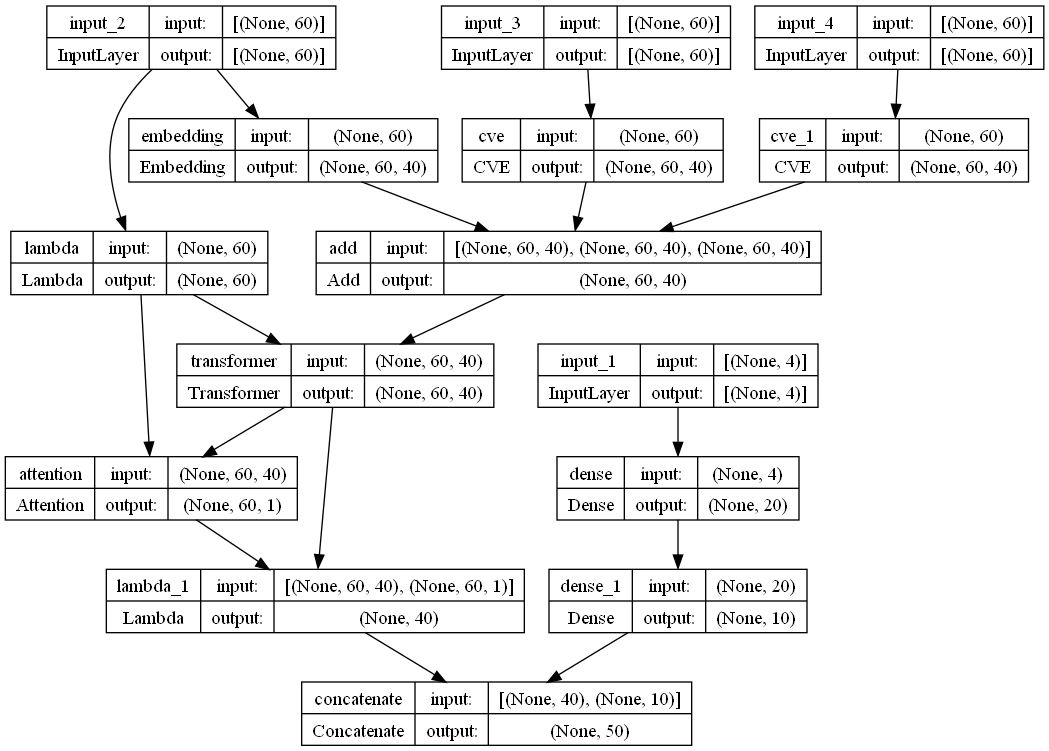

In [10]:
if DATA_SET == 'bodo':
    lr, batch_size, samples_per_epoch, patience = 0.0005, 32, 10240, 10

elif DATA_SET=='physionet':
    lr, batch_size, samples_per_epoch, patience = 0.0005, 32, 10240, 10


#########################################################################################################################
#########################################################################################################################
#NOTE: The weights get saved in the same folder as this code and not the weight folder that is used for the encoder. 
#NOTE: This is to reduce risk of overwriting  it. 
#########################################################################################################################
#########################################################################################################################


# d, N, he, dropout = 50, 2, 4, 0.2
d_var = HYPER_PARAM['d_var']  
d_demo = HYPER_PARAM['d_demo'] 
N = HYPER_PARAM['N'] 
he = HYPER_PARAM['he']  
dropout = HYPER_PARAM['dropout'] 
print(f'D={D}, fore_max_len={fore_max_len}, V={V}, d_var={d_var}, d_demo={d_demo}, N={N}, he={he}, dropout={dropout}')

encoder_model, fore_model =  build_strats(D, fore_max_len, V, d_var, d_demo, N, he, dropout, forecast=True)
print (fore_model.summary())
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))

# Pretrain fore_model.
best_val_loss = np.inf
N_fore = len(fore_train_op)


tf.keras.utils.plot_model(encoder_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [11]:
for e in range(1000):
    e_indices = np.random.choice(range(N_fore), size=samples_per_epoch, replace=False)
    e_loss = 0
    pbar = tqdm(range(0, len(e_indices), batch_size))
    for start in pbar:
        ind = e_indices[start:start+batch_size]
        e_loss += fore_model.train_on_batch([ip[ind] for ip in fore_train_ip], fore_train_op[ind])
        pbar.set_description('%f'%(e_loss/(start+1)))
    val_loss = fore_model.evaluate(fore_valid_ip, fore_valid_op, batch_size=batch_size, verbose=1)
    print ('Epoch', e, 'loss', e_loss*batch_size/samples_per_epoch, 'val loss', val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        #Save weights
        fore_model.save_weights(SAVE_WEIGHTS_AS)
        best_epoch = e
    if (e-best_epoch)>patience:
        print('break at best_epoch:', best_epoch)
        break

0.194849: 100%|██████████| 320/320 [00:08<00:00, 35.61it/s]


452/452 [==============================] - 2s 4ms/step - loss: 5.6785
Epoch 0 loss 6.216303838044405 val loss 5.678510665893555


0.165231: 100%|██████████| 320/320 [00:05<00:00, 60.54it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.9971
Epoch 1 loss 5.2713814653456215 val loss 4.9970927238464355


0.151839: 100%|██████████| 320/320 [00:05<00:00, 61.29it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.7823
Epoch 2 loss 4.844142132252455 val loss 4.782284736633301


0.141929: 100%|██████████| 320/320 [00:05<00:00, 61.09it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.5494
Epoch 3 loss 4.527981555461883 val loss 4.549375057220459


0.139230: 100%|██████████| 320/320 [00:05<00:00, 59.47it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.3510
Epoch 4 loss 4.441871339827776 val loss 4.351036071777344


0.133222: 100%|██████████| 320/320 [00:05<00:00, 59.44it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.3429
Epoch 5 loss 4.25021196603775 val loss 4.342867374420166


0.132406: 100%|██████████| 320/320 [00:05<00:00, 58.34it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.3046
Epoch 6 loss 4.224151585996151 val loss 4.304609775543213


0.130628: 100%|██████████| 320/320 [00:05<00:00, 57.36it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.2512
Epoch 7 loss 4.167451313138008 val loss 4.25119161605835


0.132431: 100%|██████████| 320/320 [00:05<00:00, 57.15it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.2650
Epoch 8 loss 4.22497700303793 val loss 4.264966011047363


0.130548: 100%|██████████| 320/320 [00:05<00:00, 58.99it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.2131
Epoch 9 loss 4.164896717667579 val loss 4.213089466094971


0.132222: 100%|██████████| 320/320 [00:05<00:00, 61.97it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.1905
Epoch 10 loss 4.2183084100484844 val loss 4.190474987030029


0.128371: 100%|██████████| 320/320 [00:05<00:00, 60.71it/s]

  1/452 [..............................] - ETA: 8s - loss: 4.7642

452/452 [==============================] - 2s 4ms/step - loss: 4.1547
Epoch 11 loss 4.095432247966528 val loss 4.154720306396484


0.127368: 100%|██████████| 320/320 [00:05<00:00, 60.91it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.1360
Epoch 12 loss 4.063446574658156 val loss 4.136012554168701


0.124928: 100%|██████████| 320/320 [00:05<00:00, 60.26it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.1361
Epoch 13 loss 3.9856071054935454 val loss 4.136068344116211


0.126976: 100%|██████████| 320/320 [00:05<00:00, 61.31it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.1566
Epoch 14 loss 4.050942825525999 val loss 4.15655517578125


0.127620: 100%|██████████| 320/320 [00:05<00:00, 62.05it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.1119
Epoch 15 loss 4.071477229148149 val loss 4.111919403076172


0.130748: 100%|██████████| 320/320 [00:05<00:00, 63.38it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0748
Epoch 16 loss 4.171282360702753 val loss 4.074777126312256


0.125964: 100%|██████████| 320/320 [00:05<00:00, 62.63it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0878
Epoch 17 loss 4.018632170557976 val loss 4.087783336639404


0.125593: 100%|██████████| 320/320 [00:05<00:00, 62.25it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.1028
Epoch 18 loss 4.006824148446322 val loss 4.1028151512146


0.122280: 100%|██████████| 320/320 [00:05<00:00, 63.75it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0663
Epoch 19 loss 3.9011190466582777 val loss 4.066320419311523


0.124145: 100%|██████████| 320/320 [00:05<00:00, 63.32it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0582
Epoch 20 loss 3.9606045968830585 val loss 4.058212757110596


0.123938: 100%|██████████| 320/320 [00:05<00:00, 63.03it/s]

  1/452 [..............................] - ETA: 8s - loss: 4.7878

452/452 [==============================] - 2s 4ms/step - loss: 4.1014
Epoch 21 loss 3.954024462774396 val loss 4.101391315460205


0.123153: 100%|██████████| 320/320 [00:04<00:00, 64.08it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0627
Epoch 22 loss 3.9289504140615463 val loss 4.062742710113525


0.123152: 100%|██████████| 320/320 [00:05<00:00, 61.16it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0448
Epoch 23 loss 3.928934343904257 val loss 4.044769763946533


0.127792: 100%|██████████| 320/320 [00:05<00:00, 61.79it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0830
Epoch 24 loss 4.076957170665264 val loss 4.082956314086914


0.124109: 100%|██████████| 320/320 [00:05<00:00, 62.11it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.1491
Epoch 25 loss 3.9594667606055736 val loss 4.149067401885986


0.123412: 100%|██████████| 320/320 [00:05<00:00, 60.51it/s]

  1/452 [..............................] - ETA: 7s - loss: 4.7330

452/452 [==============================] - 2s 4ms/step - loss: 4.0345
Epoch 26 loss 3.937239167094231 val loss 4.034547805786133


0.124831: 100%|██████████| 320/320 [00:05<00:00, 59.96it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0287
Epoch 27 loss 3.982508910447359 val loss 4.0286865234375


0.124999: 100%|██████████| 320/320 [00:05<00:00, 61.88it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0251
Epoch 28 loss 3.9878553844988347 val loss 4.025140285491943


0.124572: 100%|██████████| 320/320 [00:05<00:00, 60.99it/s]

  1/452 [..............................] - ETA: 7s - loss: 4.6525

452/452 [==============================] - 2s 4ms/step - loss: 4.0537
Epoch 29 loss 3.974232643097639 val loss 4.05371618270874


0.124995: 100%|██████████| 320/320 [00:05<00:00, 58.95it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0615
Epoch 30 loss 3.9877262622117997 val loss 4.061548709869385


0.120915: 100%|██████████| 320/320 [00:05<00:00, 62.31it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0651
Epoch 31 loss 3.8575504451990126 val loss 4.065131187438965


0.125920: 100%|██████████| 320/320 [00:05<00:00, 63.25it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0454
Epoch 32 loss 4.017226871103048 val loss 4.045389175415039


0.122682: 100%|██████████| 320/320 [00:05<00:00, 62.69it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0218
Epoch 33 loss 3.9139297269284725 val loss 4.0217742919921875


0.123173: 100%|██████████| 320/320 [00:05<00:00, 62.19it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0850
Epoch 34 loss 3.929589519649744 val loss 4.085042476654053


0.124825: 100%|██████████| 320/320 [00:05<00:00, 62.69it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0223
Epoch 35 loss 3.982304797321558 val loss 4.022273063659668


0.125659: 100%|██████████| 320/320 [00:05<00:00, 63.03it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0118
Epoch 36 loss 4.008901549875736 val loss 4.01178503036499


0.122807: 100%|██████████| 320/320 [00:05<00:00, 62.49it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0239
Epoch 37 loss 3.9179334856569765 val loss 4.02388334274292


0.125155: 100%|██████████| 320/320 [00:05<00:00, 62.23it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0282
Epoch 38 loss 3.992821864783764 val loss 4.028225421905518


0.119796: 100%|██████████| 320/320 [00:05<00:00, 61.04it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0421
Epoch 39 loss 3.8218521431088446 val loss 4.042101860046387


0.125811: 100%|██████████| 320/320 [00:05<00:00, 61.90it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0600
Epoch 40 loss 4.01376496553421 val loss 4.06004524230957


0.123224: 100%|██████████| 320/320 [00:05<00:00, 62.47it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0519
Epoch 41 loss 3.9312460757791996 val loss 4.051853656768799


0.117889: 100%|██████████| 320/320 [00:05<00:00, 58.97it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0241
Epoch 42 loss 3.7610370345413684 val loss 4.024073123931885


0.124676: 100%|██████████| 320/320 [00:05<00:00, 59.13it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9961
Epoch 43 loss 3.977549806982279 val loss 3.9960997104644775


0.122365: 100%|██████████| 320/320 [00:05<00:00, 58.78it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0214
Epoch 44 loss 3.9038109354674817 val loss 4.021421909332275


0.125091: 100%|██████████| 320/320 [00:05<00:00, 59.96it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9950
Epoch 45 loss 3.9907983131706715 val loss 3.9949560165405273


0.120967: 100%|██████████| 320/320 [00:05<00:00, 60.64it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0171
Epoch 46 loss 3.8592322655022144 val loss 4.017146587371826


0.119876: 100%|██████████| 320/320 [00:05<00:00, 58.39it/s]

  1/452 [..............................] - ETA: 8s - loss: 4.7869

452/452 [==============================] - 2s 4ms/step - loss: 4.0356
Epoch 47 loss 3.8244114220142365 val loss 4.0356221199035645


0.119450: 100%|██████████| 320/320 [00:05<00:00, 58.13it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0254
Epoch 48 loss 3.8108215339481832 val loss 4.0254011154174805


0.123748: 100%|██████████| 320/320 [00:05<00:00, 60.52it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0144
Epoch 49 loss 3.9479582630097867 val loss 4.014445781707764


0.122592: 100%|██████████| 320/320 [00:05<00:00, 60.86it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0070
Epoch 50 loss 3.911075785756111 val loss 4.007009029388428


0.122729: 100%|██████████| 320/320 [00:05<00:00, 57.92it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9822
Epoch 51 loss 3.9154384948313234 val loss 3.982205629348755


0.121540: 100%|██████████| 320/320 [00:05<00:00, 59.16it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9913
Epoch 52 loss 3.8775015167891977 val loss 3.991323471069336


0.122943: 100%|██████████| 320/320 [00:05<00:00, 60.33it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9781
Epoch 53 loss 3.9222679913043974 val loss 3.978100299835205


0.122177: 100%|██████████| 320/320 [00:05<00:00, 63.19it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9915
Epoch 54 loss 3.8978194646537303 val loss 3.991527557373047


0.121672: 100%|██████████| 320/320 [00:05<00:00, 62.63it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9828
Epoch 55 loss 3.8817273549735547 val loss 3.9828479290008545


0.122420: 100%|██████████| 320/320 [00:05<00:00, 62.88it/s]

  1/452 [..............................] - ETA: 7s - loss: 4.7714

452/452 [==============================] - 2s 4ms/step - loss: 4.0364
Epoch 56 loss 3.9055726908147337 val loss 4.036388874053955


0.123108: 100%|██████████| 320/320 [00:05<00:00, 61.99it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9804
Epoch 57 loss 3.927543244510889 val loss 3.9804229736328125


0.125063: 100%|██████████| 320/320 [00:05<00:00, 60.03it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9939
Epoch 58 loss 3.9898920319974422 val loss 3.9938714504241943


0.126111: 100%|██████████| 320/320 [00:05<00:00, 61.92it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9746
Epoch 59 loss 4.023327766358852 val loss 3.9746484756469727


0.121956: 100%|██████████| 320/320 [00:05<00:00, 59.22it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9986
Epoch 60 loss 3.890778286755085 val loss 3.998645067214966


0.119114: 100%|██████████| 320/320 [00:05<00:00, 59.24it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0393
Epoch 61 loss 3.8001149207353593 val loss 4.039276599884033


0.124116: 100%|██████████| 320/320 [00:05<00:00, 60.46it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9926
Epoch 62 loss 3.959691331535578 val loss 3.9925942420959473


0.121914: 100%|██████████| 320/320 [00:05<00:00, 59.03it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9839
Epoch 63 loss 3.889432903379202 val loss 3.9839394092559814


0.121976: 100%|██████████| 320/320 [00:05<00:00, 60.13it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9843
Epoch 64 loss 3.8914114370942117 val loss 3.9842872619628906


0.120186: 100%|██████████| 320/320 [00:05<00:00, 61.08it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0447
Epoch 65 loss 3.8343048214912416 val loss 4.044703960418701


0.123739: 100%|██████████| 320/320 [00:05<00:00, 59.56it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9585
Epoch 66 loss 3.9476634532213213 val loss 3.958451986312866


0.122041: 100%|██████████| 320/320 [00:05<00:00, 59.71it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9742
Epoch 67 loss 3.8934946328401567 val loss 3.974170684814453


0.124256: 100%|██████████| 320/320 [00:05<00:00, 59.19it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9708
Epoch 68 loss 3.964144213497639 val loss 3.9707703590393066


0.121846: 100%|██████████| 320/320 [00:05<00:00, 58.75it/s]

  1/452 [..............................] - ETA: 8s - loss: 4.4775

452/452 [==============================] - 2s 4ms/step - loss: 3.9608
Epoch 69 loss 3.8872750125825406 val loss 3.96079421043396


0.120346: 100%|██████████| 320/320 [00:05<00:00, 58.74it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9618
Epoch 70 loss 3.8394194066524507 val loss 3.9617903232574463


0.123700: 100%|██████████| 320/320 [00:05<00:00, 61.25it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9931
Epoch 71 loss 3.9464235335588453 val loss 3.9930832386016846


0.124145: 100%|██████████| 320/320 [00:05<00:00, 60.95it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9835
Epoch 72 loss 3.960629118233919 val loss 3.9834561347961426


0.119106: 100%|██████████| 320/320 [00:05<00:00, 59.30it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9663
Epoch 73 loss 3.7998504407703875 val loss 3.9663054943084717


0.121329: 100%|██████████| 320/320 [00:05<00:00, 59.39it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9737
Epoch 74 loss 3.870773198455572 val loss 3.973738193511963


0.120135: 100%|██████████| 320/320 [00:05<00:00, 58.44it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9593
Epoch 75 loss 3.8326671198010445 val loss 3.9592599868774414


0.120003: 100%|██████████| 320/320 [00:05<00:00, 58.37it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9728
Epoch 76 loss 3.8284600608050825 val loss 3.9728469848632812


0.122616: 100%|██████████| 320/320 [00:05<00:00, 57.58it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9521
Epoch 77 loss 3.9118304066359997 val loss 3.952103614807129


0.125815: 100%|██████████| 320/320 [00:05<00:00, 60.39it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9378
Epoch 78 loss 4.013881462067365 val loss 3.937833547592163


0.119376: 100%|██████████| 320/320 [00:05<00:00, 60.61it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9562
Epoch 79 loss 3.808455214649439 val loss 3.9562268257141113


0.122625: 100%|██████████| 320/320 [00:05<00:00, 59.58it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9881
Epoch 80 loss 3.912129011005163 val loss 3.988119125366211


0.122355: 100%|██████████| 320/320 [00:05<00:00, 58.77it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0089
Epoch 81 loss 3.9035101480782033 val loss 4.008873462677002


0.121499: 100%|██████████| 320/320 [00:05<00:00, 58.69it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9607
Epoch 82 loss 3.8762034378945827 val loss 3.9607062339782715


0.120564: 100%|██████████| 320/320 [00:05<00:00, 58.00it/s]


452/452 [==============================] - 2s 4ms/step - loss: 4.0068
Epoch 83 loss 3.8463669180870057 val loss 4.00680685043335


0.123942: 100%|██████████| 320/320 [00:05<00:00, 59.32it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9528
Epoch 84 loss 3.954149082303047 val loss 3.9528491497039795


0.124782: 100%|██████████| 320/320 [00:05<00:00, 60.78it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9814
Epoch 85 loss 3.9809498764574527 val loss 3.981365442276001


0.120978: 100%|██████████| 320/320 [00:05<00:00, 57.96it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9607
Epoch 86 loss 3.859571277350187 val loss 3.9607250690460205


0.123846: 100%|██████████| 320/320 [00:05<00:00, 59.73it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9605
Epoch 87 loss 3.9510668724775315 val loss 3.9604713916778564


0.121402: 100%|██████████| 320/320 [00:05<00:00, 58.08it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9590
Epoch 88 loss 3.87311689928174 val loss 3.9590439796447754


0.119298: 100%|██████████| 320/320 [00:05<00:00, 58.08it/s]


452/452 [==============================] - 2s 4ms/step - loss: 3.9534
Epoch 89 loss 3.805964580178261 val loss 3.953425168991089
break at best_epoch: 78
